In [29]:
import sys
sys.path.append("/Users/kang828/Documents/GitHub/arl-eegmodels")

import tensorflow as tf
import tensorflowjs as tfjs
import pandas as pd
import numpy as np

import seaborn as sns
import datetime

import scipy as sp
import pywt

from EEGModels import EEGNet, ShallowConvNet, DeepConvNet


In [30]:
# names = ["Chris", "Jack", "Jacob", "Karuna", "Rena"]
names = ["Jacob", "Karuna", "Rena"]
statuses = ["open", "close"]

original_files = {}

for name in names:
    for status in statuses:
        file_prefix = name + "_" + status + "_"

        for idx in range(1, 3):
            filename = file_prefix + str(idx)

            loaded_file = pd.read_pickle(filename)
            label = 1 if status == "close" else 0

            original_files[filename] = (loaded_file, label)


In [62]:
def produce_full_mat():
    names = ["Jacob", "Karuna", "Rena"]
    statuses = ["open", "close"]

    out = {}

    for name in names:
        for status in statuses:
            file_prefix = name + "_" + status + "_"

            for idx in range(1, 3):
                filename = file_prefix + str(idx)

                loaded_file = pd.read_pickle(filename)
                label = 1 if status == "close" else 0

                out[filename] = (loaded_file, label)
    return out

def produce_old_data():
    names = ["karuna", "rena"]
    statuses = ["open", "closed"]

    out = {}

    for name in names:
        for status in statuses:
            file_prefix = "./Archive/" + name + "_" + status + "_"

            for idx in range(1, 3):
                filename = file_prefix + str(idx)

                loaded_file = pd.read_pickle(filename)
                label = 1 if status == "closed" else 0

                out[filename] = (loaded_file, label)
    return out

def get_specialized_data(filename, label):
    out = {}
    loaded_file = pd.read_pickle(filename)
    out[filename] = (loaded_file, label)
    return out


In [32]:
def normalize_data(full_matrix):
    assert full_matrix.shape[1] == 4

    out = np.zeros(full_matrix.shape)
    counter = 0

    for col in full_matrix.T:

        ## want to normalize so that the average is 0
        ## and the mean is 1
        zero_mean = col - np.mean(col)
        one_std = zero_mean / np.std(zero_mean)
        out[:, counter] = one_std
        counter += 1
    
    assert out.shape == full_matrix.shape
    return out

def normalize_wavelet(full_matrix):
    assert full_matrix.shape[1] == 4

    sample_wavelets, _ = pywt.dwt(full_matrix.T[0], 'db6', mode='zero')
    out = np.zeros((len(sample_wavelets), 4))
    counter = 0

    for col in full_matrix.T:
        wavelets, _ = pywt.dwt(col, 'db6', mode="zero")
        out[:, counter] = wavelets
        # assert len(wavelets) == 6, "Constant found through testing; may be incorrect"

    return out

In [33]:
NUMBER_OF_SAMPLES_FROM_INDIV = 100
WIDTH = 600

samples = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files), 4, WIDTH))
labels = np.zeros((NUMBER_OF_SAMPLES_FROM_INDIV * len(original_files)))

counter = 0

for filename in original_files.keys():
    raw_data, label = original_files[filename]
    
    eeg_data = raw_data[[1, 2, 3, 4]].to_numpy()
    
    for _ in range(NUMBER_OF_SAMPLES_FROM_INDIV):
        start_time = np.random.randint(0, len(eeg_data) / 2 - WIDTH)

        sampled_data = eeg_data[start_time:start_time + WIDTH]

        sampled_data = normalize_data(sampled_data)
        assert sampled_data.shape == (WIDTH, 4)
        
        samples[counter] = sampled_data.T
        labels[counter] = label
        
        counter += 1



In [34]:
## shuffle the dataset
permutation = np.random.permutation(len(samples))
samples = samples[permutation]
labels = tf.one_hot(labels[permutation], 2)

In [35]:
names = ["karuna", "rena"]
statuses = ["open", "closed"]

old_files = {}

for name in names:
    for status in statuses:
        file_prefix = "./Archive/" + name + "_" + status + "_"

        for idx in range(1, 3):
            filename = file_prefix + str(idx)

            loaded_file = pd.read_pickle(filename)
            label = 1 if status == "closed" else 0

            old_files[filename] = (loaded_file, label)

In [36]:
## also sample from these files
NUMBER_OF_VALIDATION_SAMPLES = 10

val_samples = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files), 4, WIDTH))
val_labels = np.zeros((NUMBER_OF_VALIDATION_SAMPLES * len(old_files)))

counter = 0

for filename in old_files.keys():
    raw_data, label = old_files[filename]
    
    eeg_data = raw_data[[1, 2, 3, 4]].to_numpy()
    
    for _ in range(NUMBER_OF_VALIDATION_SAMPLES):
        start_time = np.random.randint(0, len(eeg_data) - WIDTH)

        sampled_data = eeg_data[start_time:start_time + WIDTH]

        sampled_data = normalize_data(sampled_data)
        assert sampled_data.shape == (WIDTH, 4)
        
        samples[counter] = sampled_data.T
        val_labels[counter] = label
        
        counter += 1

val_labels = tf.one_hot(val_labels, 2)

In [39]:
model  = ShallowConvNet(nb_classes = 2, Chans = 4, Samples = WIDTH)
# model  = EEGNet(nb_classes = 2, Chans = 4, Samples = 1000)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
fittedModel = model.fit(x=samples, y=labels, validation_data=(val_samples, val_labels), epochs=2)

Epoch 1/2
38/38 [==============================] - 2s 44ms/step - loss: 0.5410 - accuracy: 0.7350 - val_loss: 10.9845 - val_accuracy: 0.5000
Epoch 2/2
38/38 [==============================] - 2s 41ms/step - loss: 0.3032 - accuracy: 0.8667 - val_loss: 9.8026 - val_accuracy: 0.5000


In [40]:
def produce_transfer_data(filename, storage_array, NUM_SAMPLES=20):
    data_file, label = storage_array[filename]
    eeg_data = data_file[[1, 2, 3, 4]].to_numpy()

    out = np.zeros((NUM_SAMPLES, 4, WIDTH))

    for idx in range(NUM_SAMPLES):
        start_time = np.random.randint(0, len(data_file) - WIDTH)
        out[idx] = normalize_data(eeg_data[start_time:start_time + WIDTH]).T
    
    return out, np.ones(len(out)) * label

trans_data_1, trans_label_1 = produce_transfer_data("Rena_close_1", original_files)
trans_data_2, trans_label_2 = produce_transfer_data("Rena_open_1", original_files)

trans_data = np.vstack((trans_data_1, trans_data_2))
trans_label = np.append(trans_label_1, trans_label_2)

permutation = np.random.permutation(len(trans_data))
trans_data = trans_data[permutation]
trans_label = tf.one_hot(trans_label[permutation], 2)

In [41]:
model.fit(x=trans_data, y=trans_label, epochs=2)

Epoch 1/2
2/2 [==============================] - 0s 18ms/step - loss: 0.3120 - accuracy: 0.9000
Epoch 2/2
2/2 [==============================] - 0s 18ms/step - loss: 0.1911 - accuracy: 0.9500


In [50]:
# val_data_1, val_label_1 = produce_transfer_data("./Archive/rena_closed_1", old_files, NUM_SAMPLES=10)
# val_data_2, val_label_2 = produce_transfer_data("./Archive/rena_open_1", old_files, NUM_SAMPLES=10)

# val_data = np.vstack((val_data_1, val_data_2))
# val_label = np.append(val_label_1, val_label_2)

# val_label = tf.one_hot(val_label, 2)

# full_dataset = produce_full_mat()
old_dataset = produce_old_data()

test_data_1, test_label_1 = produce_transfer_data("./Archive/rena_closed_1", old_dataset, NUM_SAMPLES=50)
test_data_2, test_label_2 = produce_transfer_data("./Archive/rena_open_1", old_dataset, NUM_SAMPLES=50)

# test_data_1, test_label_1 = produce_transfer_data("Rena_close_2", full_dataset, NUM_SAMPLES=50)
# test_data_2, test_label_2 = produce_transfer_data("Rena_open_2", full_dataset, NUM_SAMPLES=50)

test_data = np.vstack((test_data_1, test_data_2))
test_label = np.append(test_label_1, test_label_2)

test_label = tf.one_hot(test_label, 2)

# permutation = np.random.permutation(len(val_data))
# val_data = val_data[permutation]
# val_label = tf.one_hot(val_label[permutation], 2)

model.evaluate(test_data, test_label)


4/4 [==============================] - 0s 6ms/step - loss: 0.9995 - accuracy: 0.6900


[0.9994533658027649, 0.6899999976158142]

In [ ]:
rena_new_data = get_specialized_data("Rena_close_3", 1)
 produce_transfer_data("Rena_close_3", rena_new_data, NUM_SAMPLES=50)

In [59]:
tf.math.confusion_matrix(tf.argmax(test_label, axis=1), tf.argmax(model.predict(test_data), axis=1))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[29, 21],
       [10, 40]], dtype=int32)>

In [43]:
model.predict(test_data_1)

array([[0.21495523, 0.7850447 ],
       [0.28473392, 0.71526605],
       [0.14869635, 0.85130364],
       [0.8353638 , 0.16463621],
       [0.1074936 , 0.8925064 ],
       [0.30652967, 0.6934703 ],
       [0.15095805, 0.849042  ],
       [0.48739284, 0.51260716],
       [0.44406593, 0.5559341 ],
       [0.30079252, 0.69920754],
       [0.42581058, 0.5741894 ],
       [0.44853708, 0.55146295],
       [0.3872995 , 0.6127005 ],
       [0.864406  , 0.13559403],
       [0.13155892, 0.8684411 ],
       [0.2065958 , 0.7934042 ],
       [0.887846  , 0.11215399],
       [0.04353999, 0.95646006],
       [0.1587515 , 0.8412485 ],
       [0.27047023, 0.72952974],
       [0.1375339 , 0.86246604],
       [0.8596214 , 0.1403786 ],
       [0.02503595, 0.974964  ],
       [0.4391524 , 0.56084764],
       [0.36323416, 0.63676584],
       [0.09977125, 0.90022874],
       [0.3981487 , 0.6018513 ],
       [0.12876238, 0.87123764],
       [0.4460461 , 0.5539539 ],
       [0.20070797, 0.799292  ],
       [0.

In [51]:
!mkdir -p saved_model
model.save('saved_model/my_model')

2022-04-03 14:15:09.572108: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


<AxesSubplot:>

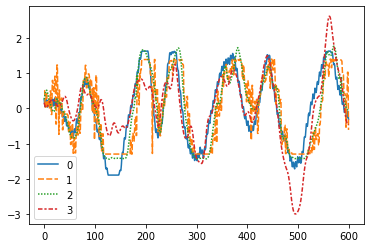

In [55]:
sns.lineplot(data=test_data[1].T)